In [7]:
import torch

from torch import nn
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torchvision import datasets
import torchvision

In [9]:
# Use your own path ;)
datasets.MNIST.resources = [
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
        ]
mnist_train = torchvision.datasets.MNIST('Data/mnist', train=True, download=True,
                                         transform=torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor()
                                         ]))

0it [00:00, ?it/s]

9920512it [05:02, 32287.10it/s]                             

Extracting Data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to Data/mnist/MNIST/raw



0it [00:00, ?it/s]


  0%|          | 0/28881 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Extracting Data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to Data/mnist/MNIST/raw




  0%|          | 0/1648877 [00:00<?, ?it/s]

  1%|          | 16384/1648877 [00:00<00:21, 74336.25it/s]

  1%|▏         | 24576/1648877 [00:00<00:38, 42475.70it/s]

  2%|▏         | 32768/1648877 [00:01<00:46, 34592.25it/s]

  2%|▏         | 40960/1648877 [00:01<00:40, 40124.65it/s]

  3%|▎         | 49152/1648877 [00:01<00:44, 36330.93it/s]

  3%|▎         | 57344/1648877 [00:01<00:48, 32785.36it/s]

  4%|▍         | 65536/1648877 [00:02<00:45, 34573.30it/s]

  4%|▍         | 73728/1648877 [00:02<00:46, 34164.78it/s]

  5%|▍         | 81920/1648877 [00:02<00:46, 33571.33it/s]

  5%|▌         | 90112/1648877 [00:02<00:50, 30630.18it/s]

  6%|▌         | 98304/1648877 [00:03<00:46, 33491.91it/s]

  6%|▋         | 106496/1648877 [00:03<00:46, 33041.25it/s]

  7%|▋         | 114688/1648877 [00:03<00:47, 32257.31it/s]

  7%|▋         | 122880/1648877 [00:03<00:46, 32638.24it/s]

  8%|▊         | 131072/1648877 [00:04<00:46, 32343.45it/s]

  8%|▊         | 139264/1648877 [00:04<00:46, 322

 61%|██████    | 1007616/1648877 [00:30<00:20, 31391.97it/s]

 62%|██████▏   | 1015808/1648877 [00:31<00:18, 33641.91it/s]

 62%|██████▏   | 1024000/1648877 [00:31<00:17, 36094.19it/s]

 63%|██████▎   | 1032192/1648877 [00:31<00:17, 35432.39it/s]

 63%|██████▎   | 1040384/1648877 [00:31<00:18, 32972.83it/s]

 64%|██████▎   | 1048576/1648877 [00:32<00:17, 34783.45it/s]

 64%|██████▍   | 1056768/1648877 [00:32<00:15, 37474.38it/s]

 65%|██████▍   | 1064960/1648877 [00:32<00:15, 37236.13it/s]

 65%|██████▌   | 1073152/1648877 [00:32<00:17, 32991.80it/s]

 66%|██████▌   | 1081344/1648877 [00:32<00:15, 36655.44it/s]

 66%|██████▌   | 1089536/1648877 [00:33<00:16, 34024.46it/s]

 67%|██████▋   | 1097728/1648877 [00:33<00:16, 33466.88it/s]

 67%|██████▋   | 1105920/1648877 [00:33<00:15, 35759.33it/s]

 68%|██████▊   | 1114112/1648877 [00:34<00:17, 31396.16it/s]

 68%|██████▊   | 1122304/1648877 [00:34<00:14, 36270.11it/s]

 69%|██████▊   | 1130496/1648877 [00:34<00:14, 35640.95it/s]

 69%|███

Extracting Data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to Data/mnist/MNIST/raw





  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting Data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to Data/mnist/MNIST/raw
Processing...
Done!




1654784it [01:05, 34710.37it/s]

In [167]:
x_train = mnist_train.data.type(torch.float32)
x_train /= 255.
y_train = mnist_train.targets

n_val = 100
x_val = x_train[0:n_val,:,:]
x_train = x_train[n_val:,:,:]
y_val = y_train[0:n_val]
y_train = y_train[n_val:]

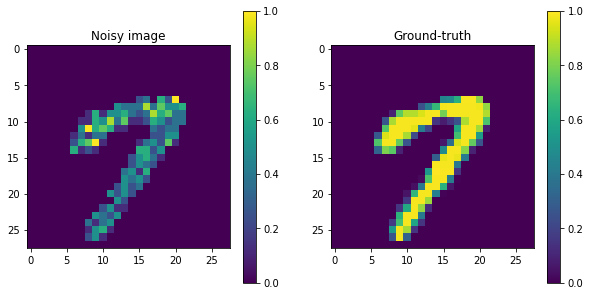

In [309]:
y_denoise = mnist_train.data.type(torch.float32)

# extract validation set
y_denoise_val = y_denoise[0:n_val,:,:]
y_denoise = y_denoise[100:,:,:]

noise_level=2.0**((-6))
noisy_images = []
for i in range(y_denoise.size(0)-n_val):
    im = np.random.poisson(y_denoise[i,:,:]*noise_level) # multiply by noise level and poisson-disturb
    noisy_images.append(im / np.max(im)) # normalize

x_denoise = torch.FloatTensor(noisy_images)
y_denoise /= 255.

# same for validation set
noisy_images = []
for i in range(n_val):
    im = np.random.poisson(y_denoise_val[i,:,:]*noise_level) # multiply by noise level and poisson-disturb
    noisy_images.append(im / np.max(im)) # normalize

x_denoise_val = torch.FloatTensor(noisy_images)
y_denoise_val /= 255.
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x_denoise[25])
plt.colorbar()
plt.title('Noisy image');
plt.subplot(1,2,2)
plt.imshow(y_denoise[25])
plt.colorbar()
plt.title('Ground-truth');

In [168]:
print(x_train.shape)
print(y_train.shape)

torch.Size([59900, 28, 28])
torch.Size([59900])


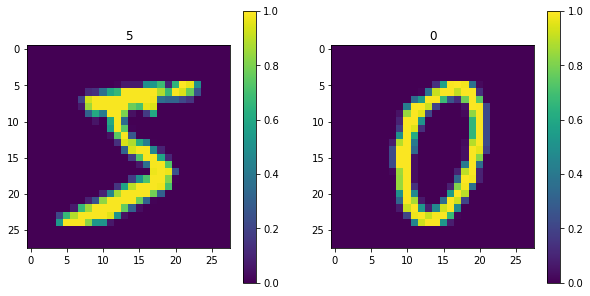

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.colorbar()
plt.title(y_train[0].item());
plt.subplot(1,2,2)
plt.imshow(x_train[1000])
plt.colorbar()
plt.title(y_train[1000].item());

# Tasks
* Train a classifier with fully-connected layers only.
* Train a classifier with convolutions only.
* Train a classifier with convolutions and fully-connected layers.
* Train a denoising network. Note, you have to create some noisy observations first ;)

# 1. Create model

In [295]:
mnist_size = 28
n_classes = 10

class DenseNN(nn.Module):
    def __init__(self, args = [3, 10]):
        super(DenseNN, self).__init__()
        
        self.input_layer = nn.Linear(mnist_size*mnist_size, args[1])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(args[0]):
            self.hidden_layers.append(nn.Linear(args[1],args[1]))
            
        self.output_layer = nn.Linear(args[1], n_classes)        
        
    def forward(self, x):
        
        x = torch.flatten(x)
        x = F.relu(self.input_layer(x))
        
        for layer in self.hidden_layers:
            x =  F.relu(layer(x))
        
        # nn.Softmax is a layer and not an activation function
        return F.softmax(self.output_layer(x), dim=-1)
    
    def get_loss_and_optimizer(self):
        return F.cross_entropy, torch.optim.Adam(self.parameters(), lr=0.0001)

class CvNN(nn.Module):
    def __init__(self, args = []):
        super(CvNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 10, kernel_size=3, stride=1, padding=0),
            nn.Softmax(),
            nn.Flatten())
        
    def forward(self, x):
        
        x = self.conv1(x[None, None, ...])
        x = self.conv2(x)
        x = self.conv3(x)
        
        return self.conv4(x)
    
    def get_loss_and_optimizer(self):
        return F.cross_entropy, torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)

class CvDenseNN(nn.Module):
    def __init__(self, args = [3, 10]):
        super(CvDenseNN, self).__init__()
  
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten())
        
        self.dense = nn.ModuleList()
        self.dense.append(nn.Linear(32,args[1]))
        for i in range(args[0]-1):
            self.dense.append(nn.Linear(args[1],args[1]))
            
        self.output_layer = nn.Linear(args[1], n_classes)    
        
    def forward(self, x):
        
        x = self.conv1(x[None, None, ...])
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        for layer in self.dense:
            x =  F.relu(layer(x))
        
        return F.softmax(self.output_layer(x), dim=-1)
    
    def get_loss_and_optimizer(self):
        return F.cross_entropy, torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)

class Unet(nn.Module):
    def __init__(self, args = []):
        super(Unet, self).__init__()

        self.conv1 = self.contract_block(1, 32, 7, 2)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, 1, 2, 1)

    def forward(self, x):
        # downsampling part
        conv1 = self.conv1(x[None, None, ...]) # torch expect 4D
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)
        
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand
            
    def get_loss_and_optimizer(self):
        return F.mse_loss, torch.optim.Adam(self.parameters(), lr=0.0001)

class ModelFactory():
    def get_model(self, model = 'DenseNN', args = [5, 10]):
        return globals()[model](args)

factory = ModelFactory()

# 2. Test if model runs

In [307]:
model = factory.get_model('Unet')
print(model)

#example = x_train[10]
example = x_denoise[15]

#model(example)
assert example.size() == torch.squeeze(model(example)).size()

Unet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kerne

# 3. Choose loss-function and optimizer

In [308]:
loss_function, optimizer = model.get_loss_and_optimizer()

# 4. Write train-loop

__Note:__ If you want to train on GPU just call `model.cuda()` to move the model to GPU. Don't forget to move the training data to GPU as well. You can call `x.cuda()` to move a tensor to GPU.

In [324]:
def train(name, model, x, y, x_val, y_val, loss_function, optimizer, num_epochs):
    # Make sure that the model is in train-mode
    model.train()
    
    print('-----------------------------')
    print('-----------------------------')
    print('Training ', name)
    print('-------------')
    
    running_loss = 0.0
    for e in tqdm(range(num_epochs)):
        for x_, y_ in zip(x, y):
            x_ = x_
            
            if name != 'Unet':
                y_ = y_.unsqueeze(0)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            y_hat = model(x_)
            if len(y_hat.size()) < 2:
                y_hat.unsqueeze(0)
            
            if name == 'Unet':
                y_hat = torch.squeeze(y_hat)
                       
            loss = loss_function(y_hat, y_)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() # .item() returns the scalar value of the tensor.
                        
        running_loss /= len(x)
        if e % 100 == 0:
            running_loss /= 100.
            
            if name == 'Unet':
                model.eval()
                
                val_loss = 0
                with torch.no_grad():
                    for noisy, gt in zip(x_val, y_val):
                        denoised = model(noisy)
                        val_loss += (np.square(denoised - gt)).mean().mean()
                
                val_loss /= y_val.size(0)
                model.train()
            else:
                # evaluate on validation set
                model.eval()
                with torch.no_grad():
                    correct = 0
                    total = 0
                    for image, label in zip(x_val, y_val):
                        output = model(image)
                        predicted = torch.argmax(output)
                        total += 1
                        correct += predicted == label

                model.train()

                val_loss = float(correct) / float(total)
                
            print('Epoch: {:4}; Train-Loss: {}, Validation-Loss: {}'.format(e, np.round(running_loss, 3), np.round(val_loss, 3)))
            running_loss = 0.0

# 4b - Check if it overfits

__Note:__ If you want to train on GPU just call `model.cuda()` to move the model to GPU. Don't forget to move the training data to GPU as well. You can call `x.cuda()` to move a tensor to GPU.

-----------------------------
-----------------------------
Training  Unet
-------------


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch:    0; Train-Loss: 0.0, Validation-Loss: 0.05999999865889549


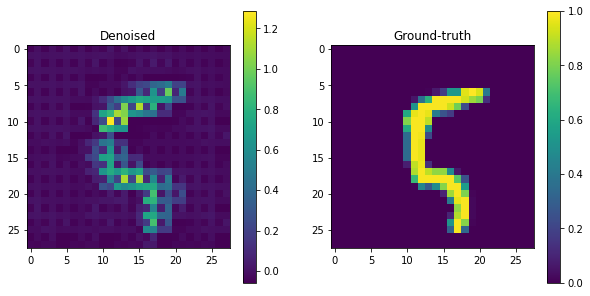

In [327]:
classification = False

if classification:
    x = torch.stack( [x_train[0] for i in range(50)] )
    y = torch.stack([y_train[0] for i in range(50)] ) # cross entropy does not expect one-hot encoded

    train('', model, x, y, x_val, y_val, loss_function, optimizer, 50)

    # Check that it overfitted
    result = model(x_train[0])
    print(result)
    assert torch.argmax(result) == y_train[0]
else:
    x = torch.stack( [x_denoise[0] for i in range(50)] )
    y = torch.stack( [y_denoise[0] for i in range(50)] ) # cross entropy does not expect one-hot encoded

    train('Unet', model, x, y, x_denoise_val, y_denoise_val, loss_function, optimizer, 2)

    # Check that it overfitted
    result = torch.squeeze(model(x_denoise[0])).detach().numpy()
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(result)
    plt.colorbar()
    plt.title('Denoised');
    plt.subplot(1,2,2)
    plt.imshow(y_denoise[0])
    plt.colorbar()
    plt.title('Ground-truth');

# 5. Evaluate

In [193]:
train_classification('', model, x_train, y_train, x_val, y_val, loss_function, optimizer, 100)

-----------------------------
-----------------------------
Training  
-------------


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 